## Importing necessary packages

In [6]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, LeaveOneOut, StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap
import warnings

warnings.filterwarnings("ignore")

## Defining constants

In [42]:
EXPERIMENT = "EPM"

DATASET_PATH = "../../data/12_classification_dataset/EPM_data.csv"
LABELS_PATH  = "../../data/12_classification_dataset/video_anxiety_labels_for_ML_moreLabels_march_2022.xlsx"

LABELS = [
    "High_Anxiety",
    "Middle_Anxiety",
    "Low_Anxiety"
]

## Data Preprocessing

In [39]:
def get_trial_number(video_name: str) -> int:
    result = video_name.split('_')
    return int(result[1])

def preprocess_labels(labels: pd.DataFrame) -> pd.DataFrame:
    labels = labels.dropna()
    encodings = pd.get_dummies(labels["labels"])
    labels = pd.concat([labels, encodings], axis=1)
    labels = labels.drop(columns=["test", "labels"])
    labels = labels.rename(columns={
        "high anxiety": "High_Anxiety",
        "mid anxiety": "Middle_Anxiety",
        "low anxiety": "Low_Anxiety"
    })
    
    return labels

def merge_dataset_and_labels(df: pd.DataFrame, labels: pd.DataFrame) -> pd.DataFrame:
    df = df[df["is_week_6"] == 1]
    df["trial_number"] = df["video_name"].map(get_trial_number)
    df = df.merge(labels, how="inner", on=["set", "trial_number"])
    df.drop(columns="week", inplace=True)
    
    return df

def save_new_dataset(dataset_path: str, result_path: str, experiment="EPM"):
    labels = pd.read_excel(LABELS_PATH, engine="openpyxl")
    labels = labels[labels["test"] == experiment]
    labels = preprocess_labels(labels)
    
    df = pd.read_csv(dataset_path)
    df = merge_dataset_and_labels(df, labels)
    df.to_csv(result_path)

def plot_labels_distribution(df: pd.DataFrame, experiment_name: str):
    targets = ["High_Anxiety", "Middle_Anxiety", "Low_Anxiety"]
    counts = df[targets].sum().values
    
    plt.figure(figsize=(8, 8))
    plt.bar(targets, counts, color=["orangered", "lightsalmon", "bisque"])
    plt.title(f"Labels distribution for the {experiment_name}", fontsize=16)
    plt.ylabel("Frequency", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(np.arange(0, 30, 2), fontsize=12)
    plt.grid(axis="y")
    plt.show()
    
def preprocess_dataset(df: pd.DataFrame) -> pd.DataFrame:
    df.drop(columns=["video_name", "set", "trial_number", "has_treatment", "is_week_6"], inplace=True)
    return df

In [40]:
def read_labels(labels_path):
    labels = pd.read_excel(labels_path, engine="openpyxl")
    labels = labels[labels["test"] == EXPERIMENT]
    labels = preprocess_labels(labels)
    return labels

def get_test_labels(labels, train_labels):
    test_labels = pd.merge(train_labels, labels, on=["set", "week", "trial_number"], how="right", indicator=True).loc[lambda x: x["_merge"] == "right_only"]
    test_labels.drop(columns=["High_Anxiety_x", "Middle_Anxiety_x", "Low_Anxiety_x", "_merge"], inplace=True)
    test_labels.rename(columns={
        "High_Anxiety_y": "High_Anxiety", 
        "Middle_Anxiety_y": "Middle_Anxiety", 
        "Low_Anxiety_y": "Low_Anxiety"
    }, inplace=True)
    return test_labels

def read_dataset(dataset_path, labels):
    df = pd.read_csv(dataset_path)
    df = merge_dataset_and_labels(df, labels)
    df = preprocess_dataset(df)
    return df

def get_labels_dataset(df):
    mapping = {
        0: 1,
        1: 2,
        2: 3
    }
    
    y = df[LABELS]
    y = [mapping[2 - np.argmax(row)] for row in y.values]

    df.drop(columns=LABELS, inplace=True)
    df.head()
    return y
    
def get_dataset():
    all_labels = read_labels(LABELS_PATH)
    X = read_dataset(DATASET_PATH, all_labels)
    y = get_labels_dataset(X)
    
    return X, y

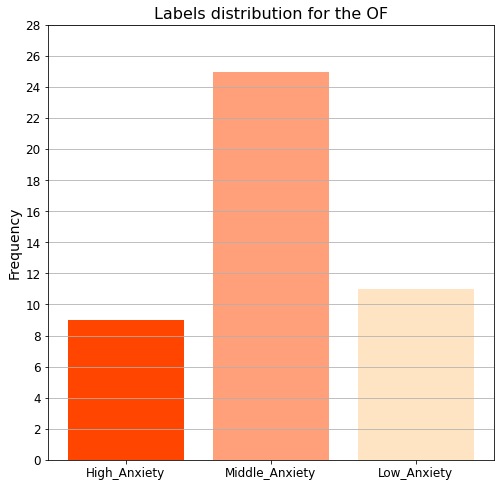

In [41]:
all_labels = read_labels(LABELS_PATH)
plot_labels_distribution(all_labels, "EPM")

In [10]:
X, y = get_dataset()

## Regression

In [12]:
def regression_accuracy(y_true, y_pred, **kwargs):
    total = len(y_true)
    correct = 0
    
    for i, j in zip(y_true, y_pred):
        if i == round(j):
            correct += 1
            
    return correct / total

In [13]:
def calculate_metrics(model, X, y, metrics):
    skf = StratifiedKFold(n_splits=7, shuffle=True, random_state=0)
    
    scorings = {}
    
    for scoring in metrics:
        if scoring == "neg_root_mean_squared_error":
            metric = scoring
            sign = -1
        else:
            sign = 1
            metric = make_scorer(regression_accuracy, greater_is_better=True)
            
        skf_scores = cross_val_score(model, X, y, cv=skf, scoring=metric)

        scorings[scoring] = np.round(sign * np.mean(skf_scores), 3)
    
    return scorings

In [14]:
def data_preprocessing(X, y, preprocessing, n_components):
    datasets = {}
    temp_X = X.copy()
    
    if len(preprocessing) == 0:
        print("Error! No preprocessing techniques were provided. Available techniques are: selectkbset, pca, umap, total.")
    
    for technique in preprocessing:
        if technique == "selectkbest":
            selector = SelectKBest(chi2, k=n_components)
            temp_X   = selector.fit_transform(temp_X.replace(-1, 999), y)
            
        scaler = StandardScaler()
        temp_X = scaler.fit_transform(temp_X)
        
        if technique == "pca":
            pca    = PCA(n_components=n_components, random_state=0)
            temp_X = pca.fit_transform(temp_X)
        elif technique == "umap":
            UMAP   = umap.UMAP(n_components=n_components, random_state=0, n_jobs=-1)
            temp_X = UMAP.fit_transform(temp_X)
        elif technique != "selectkbest":
            continue
        
        datasets[technique] = temp_X
        
    return datasets

In [15]:
def test_model(model, X: pd.DataFrame, y, n_components=10, preprocessing=["selectkbest", "pca", "umap"], 
               metrics=["accuracy", "neg_root_mean_squared_error"]) -> pd.DataFrame:
    results = {}
    all_scores = {}
    
    results = pd.DataFrame(columns=[
        "n_components", 
        "dataset_type", 
        "stratified-kfold acc",
        "stratified-kfold rmse"
    ])
    
    for n in range(1, n_components+1):
        datasets = data_preprocessing(X, y, preprocessing, n)
        
        for name, dataset in datasets.items():
            scores = calculate_metrics(model, dataset, y, metrics)
            row_values = [n, name]
            
            for metric, score in scores.items():
                row_values.append(score)
            
            results = results.append({k: v for k, v in zip(results, row_values)}, ignore_index=True)
                
        print(f"Number of components finished: {n} out of {n_components}", end='\r')
                    
    return results

In [21]:
# best: 0.549, 66.3%, 10, pca (max_depth=1)
model = DecisionTreeRegressor(max_depth=4, random_state=0)

results = test_model(model, X, y)
results.sort_values(["stratified-kfold rmse", "stratified-kfold acc", "n_components"], ascending=True)

,n_components,dataset_type,stratified-kfold acc,stratified-kfold rmse
28,10,pca,0.687,0.642
22,8,pca,0.656,0.685
7,3,pca,0.609,0.687
11,4,umap,0.568,0.732
3,2,selectkbest,0.612,0.733
2,1,umap,0.473,0.757
6,3,selectkbest,0.561,0.769
9,4,selectkbest,0.561,0.769
29,10,umap,0.520,0.776
0,1,selectkbest,0.476,0.780


In [23]:
# best: 0.641, 56.8%, 3, selectkbest or pca (default)
model = SGDRegressor(random_state=0)

results = test_model(model, X, y)
results.sort_values(["stratified-kfold rmse", "stratified-kfold acc", "n_components"], ascending=True)

,n_components,dataset_type,stratified-kfold acc,stratified-kfold rmse
6,3,selectkbest,0.568,6.410000e-01
7,3,pca,0.568,6.410000e-01
3,2,selectkbest,0.544,6.500000e-01
4,2,pca,0.544,6.500000e-01
0,1,selectkbest,0.480,6.720000e-01
1,1,pca,0.480,6.720000e-01
9,4,selectkbest,0.524,6.740000e-01
10,4,pca,0.524,6.740000e-01
12,5,selectkbest,0.456,6.890000e-01
13,5,pca,0.456,6.890000e-01


In [29]:
# best: 0.645, 54.4%, 2, selectkbest or pca (kernel="poly", degree=2)
model = SVR(kernel="poly", degree=5)

results = test_model(model, X, y)
results.sort_values(["stratified-kfold rmse", "stratified-kfold acc", "n_components"], ascending=True)

,n_components,dataset_type,stratified-kfold acc,stratified-kfold rmse
3,2,selectkbest,0.544,0.645
4,2,pca,0.544,0.645
29,10,umap,0.592,0.689
14,5,umap,0.548,0.693
2,1,umap,0.503,0.700
0,1,selectkbest,0.432,0.711
1,1,pca,0.432,0.711
5,2,umap,0.456,0.737
27,10,selectkbest,0.500,0.739
28,10,pca,0.500,0.739


In [34]:
# best: 0.576, 66.0%, 10, pca (default)
model = RandomForestRegressor(n_jobs=-1, random_state=0)

results = test_model(model, X, y)
results.sort_values(["stratified-kfold rmse", "stratified-kfold acc", "n_components"], ascending=True)

,n_components,dataset_type,stratified-kfold acc,stratified-kfold rmse
28,10,pca,0.660,0.576
22,8,pca,0.619,0.596
25,9,pca,0.639,0.656
20,7,umap,0.548,0.660
29,10,umap,0.524,0.662
16,6,pca,0.639,0.666
15,6,selectkbest,0.639,0.674
6,3,selectkbest,0.636,0.684
12,5,selectkbest,0.660,0.684
27,10,selectkbest,0.588,0.685


In [33]:
# best: 0.536, 70.7%, 8, selectkbest or pca (default)
model = KNeighborsRegressor(n_neighbors=5, weights="distance", n_jobs=-1)

results = test_model(model, X, y)
results.sort_values(["stratified-kfold rmse", "stratified-kfold acc", "n_components"], ascending=True)

,n_components,dataset_type,stratified-kfold acc,stratified-kfold rmse
21,8,selectkbest,0.663,0.566
22,8,pca,0.663,0.568
20,7,umap,0.568,0.624
24,9,selectkbest,0.639,0.637
15,6,selectkbest,0.660,0.638
16,6,pca,0.660,0.639
18,7,selectkbest,0.639,0.642
12,5,selectkbest,0.636,0.643
13,5,pca,0.636,0.643
27,10,selectkbest,0.639,0.643
